In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Load the Data

In [10]:
X_train = pickle.load(open('../Data/X_train.pkl', 'rb'))
X_test = pickle.load(open('../Data/X_test.pkl', 'rb'))
y_train = pickle.load(open('../Data/y_train.pkl', 'rb'))
y_test = pickle.load(open('../Data/y_test.pkl', 'rb'))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(329, 20530)
(83, 20530)
(329,)
(83,)


## Standardize the Data

In [11]:
# standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(329, 20530)
(83, 20530)


# Keeping 99% of variance
Let's first test how many components we need to keep 99% of variance.

In [12]:
from sklearn.decomposition import PCA
import pandas as pd

# Initialize PCA with n_components=0.99
pca = PCA(n_components=0.99)

reduced_X_train = pca.fit_transform(X_train)

selected_components = pca.n_components_
print(f"Number of components selected to explain 99% of variance: {selected_components}")

Number of components selected to explain 99% of variance: 308


In [13]:
reduced_X_train.shape

(329, 308)

In [14]:
X_test.shape

(83, 20530)

In [15]:
reduced_X_test = pca.transform(X_test)

reduced_X_test.shape

(83, 308)

### Exhausive search for finding the best parameters for SVM model

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

# Create a GridSearchCV object
search = GridSearchCV(SVC(probability=True), parameters, n_jobs=-1, verbose=2, cv=3)

# Fit the grid search to the data
search.fit(reduced_X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['rbf']}],
             verbose=2)

In [18]:
best_params = search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 1, 'kernel': 'linear'}


In [19]:
best_model = search.best_estimator_
best_model

SVC(C=1, kernel='linear', probability=True)

In [20]:
search.cv_results_

{'mean_fit_time': array([0.03728541, 0.02792303, 0.02394032, 0.02194126, 0.10043915,
        0.10757772, 0.120845  , 0.09933678, 0.08571259, 0.08772985,
        0.10961405, 0.09816813, 0.08596508, 0.09243766, 0.11192671,
        0.08648562, 0.09122785, 0.08591127, 0.08876268, 0.08297523,
        0.07998816, 0.09255211, 0.09922902, 0.13907973, 0.13403845,
        0.09978604, 0.13327901, 0.10762135, 0.09826724, 0.1098032 ,
        0.1319135 , 0.09918857, 0.09942325, 0.08447989, 0.08357763,
        0.08463709, 0.10062909, 0.08637071, 0.08014687, 0.08137767]),
 'std_fit_time': array([0.00750736, 0.00293499, 0.00141361, 0.00162898, 0.01372878,
        0.01509395, 0.01139653, 0.02899899, 0.0074652 , 0.01211357,
        0.02057647, 0.02442788, 0.00648928, 0.00343601, 0.01234867,
        0.00529427, 0.00678553, 0.00651127, 0.00991483, 0.01031684,
        0.00550904, 0.00946656, 0.00068207, 0.01410673, 0.03167236,
        0.00335861, 0.0199013 , 0.00563011, 0.01665374, 0.02901582,
        0.020

In [21]:
best_score = search.best_score_     # this is accuracy score
print("Best Score:", best_score)    

Best Score: 0.9392549346677788


In [22]:
from sklearn.metrics import accuracy_score

y_pred_test = best_model.predict(reduced_X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Set Accuracy:", test_accuracy)

Test Set Accuracy: 0.9156626506024096


In [23]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, y_pred_test)
print("AUC Score:", auc_score)

AUC Score: 0.8526119402985075


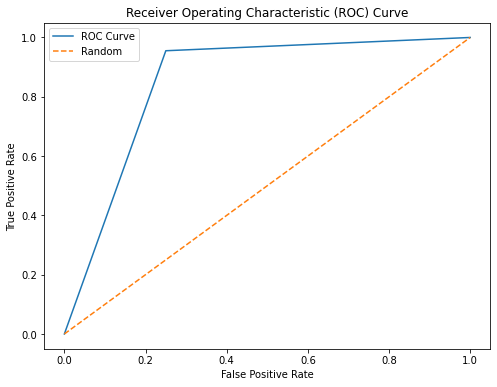

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

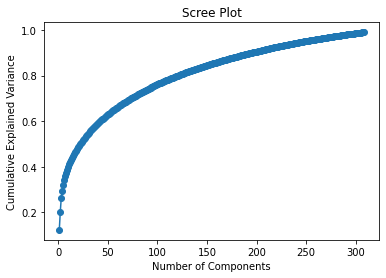

In [25]:
# Scree plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

# Experimenting with the number of components to keep
Now let's experiment with the number of components to find how many components we need to keep to get the best accuracy.

### n_components = 50, 100, 150, ..., 300

In [23]:
from sklearn.metrics import roc_auc_score

test_accuracy_list = []
auc_score_list = []

for n_components in range(50, 300, 50):
    pca = PCA(n_components=n_components)
    reduced_X_train = pca.fit_transform(X_train)
    reduced_X_test = pca.transform(X_test)

    model = SVC(C=1, kernel='linear', probability=True)
    model.fit(reduced_X_train, y_train)
    y_pred_test = model.predict(reduced_X_test)

    test_accuracy = accuracy_score(y_test, y_pred_test)
    auc_score = roc_auc_score(y_test, y_pred_test)

    test_accuracy_list.append(test_accuracy)
    auc_score_list.append(auc_score)

    print(f"n_components: {n_components}, Test Set Accuracy: {test_accuracy}, AUC Score: {auc_score}")
    print()

n_components: 50, Test Set Accuracy: 0.891566265060241, AUC Score: 0.8138992537313432

n_components: 100, Test Set Accuracy: 0.891566265060241, AUC Score: 0.8138992537313432

n_components: 150, Test Set Accuracy: 0.9036144578313253, AUC Score: 0.8451492537313433

n_components: 200, Test Set Accuracy: 0.9156626506024096, AUC Score: 0.8526119402985075

n_components: 250, Test Set Accuracy: 0.9036144578313253, AUC Score: 0.8213619402985075



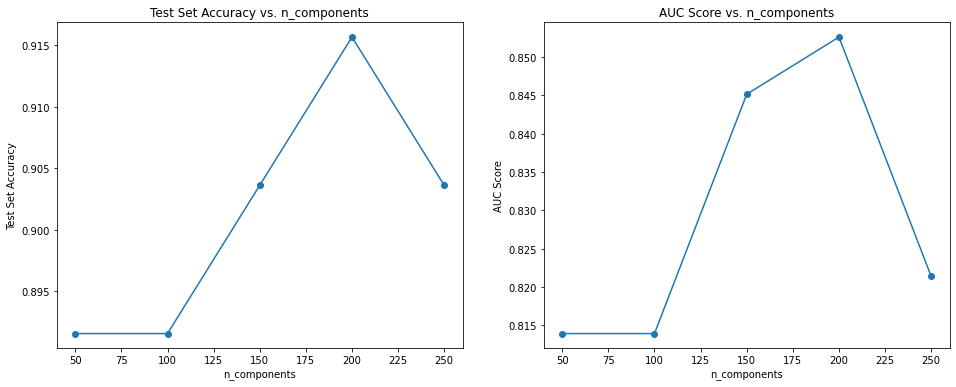

In [26]:
# plot two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# plot test accuracy
ax[0].plot(range(50, 300, 50), test_accuracy_list, marker='o')
ax[0].set_xlabel('n_components')
ax[0].set_ylabel('Test Set Accuracy')
ax[0].set_title('Test Set Accuracy vs. n_components')

# plot auc score
ax[1].plot(range(50, 300, 50), auc_score_list, marker='o')
ax[1].set_xlabel('n_components')
ax[1].set_ylabel('AUC Score')
ax[1].set_title('AUC Score vs. n_components')

plt.show()

Let's find on a more granular level.
### n_components = 150 to 329

[Note : PCA has to be applied within the dim of min(num_samples, num_features) and here 329 samples and 20530 features]

In [27]:
from sklearn.metrics import roc_auc_score

train_accuracy_list = []
test_accuracy_list = []
auc_score_list = []
max_acc = -999
optimal_model = None
optimal_n_components = None
optimal_x_train = None
optimal_x_test = None
optimal_predictions = None

parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

for n_components in range(150, X_train.shape[0]):
    pca = PCA(n_components=n_components)
    reduced_X_train = pca.fit_transform(X_train)
    reduced_X_test = pca.transform(X_test)

    search = GridSearchCV(SVC(probability=True), parameters, n_jobs=-1, verbose=2, cv=3)
    search.fit(reduced_X_train, y_train)
    model = search.best_estimator_

    train_accuracy = search.best_score_
    test_accuracy = search.score(reduced_X_test, y_test)
    y_pred_test = model.predict(reduced_X_test)
    auc_score = roc_auc_score(y_test, y_pred_test)

    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    auc_score_list.append(auc_score)

    # for saving the best model
    if test_accuracy > max_acc:
        max_acc = test_accuracy
        optimal_model = model
        optimal_n_components = n_components
        optimal_x_train = reduced_X_train
        optimal_x_test = reduced_X_test
        optimal_predictions = y_pred_test

    print(f"n_components: {n_components}, Train Set Accuracy: {train_accuracy}, Test Set Accuracy: {test_accuracy}, AUC Score: {auc_score}")
    print()

Fitting 3 folds for each of 40 candidates, totalling 120 fits
n_components: 150, Train Set Accuracy: 0.8844314706700028, Test Set Accuracy: 0.9036144578313253, AUC Score: 0.8451492537313433

Fitting 3 folds for each of 40 candidates, totalling 120 fits
n_components: 151, Train Set Accuracy: 0.9088128996385878, Test Set Accuracy: 0.9036144578313253, AUC Score: 0.8451492537313433

Fitting 3 folds for each of 40 candidates, totalling 120 fits
n_components: 152, Train Set Accuracy: 0.9027800945232137, Test Set Accuracy: 0.9156626506024096, AUC Score: 0.8526119402985075

Fitting 3 folds for each of 40 candidates, totalling 120 fits
n_components: 153, Train Set Accuracy: 0.8905476786210732, Test Set Accuracy: 0.9036144578313253, AUC Score: 0.8451492537313433

Fitting 3 folds for each of 40 candidates, totalling 120 fits
n_components: 154, Train Set Accuracy: 0.9088128996385877, Test Set Accuracy: 0.9036144578313253, AUC Score: 0.8451492537313433

Fitting 3 folds for each of 40 candidates, to

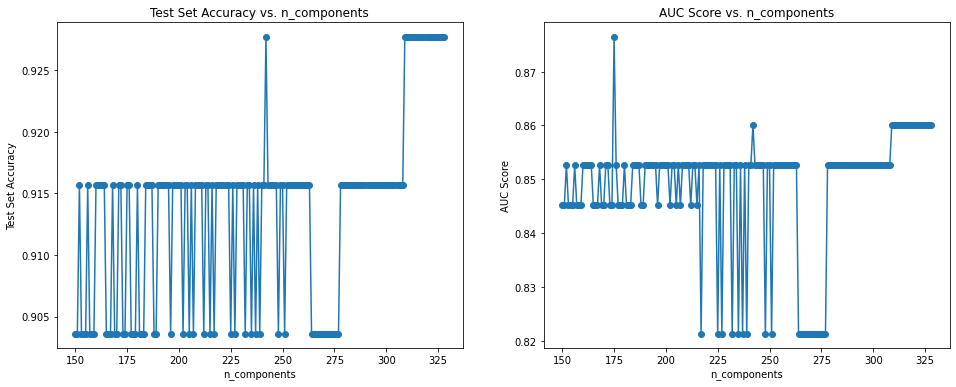

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(range(150, X_train.shape[0]), test_accuracy_list, marker='o')
ax[0].set_xlabel('n_components')
ax[0].set_ylabel('Test Set Accuracy')
ax[0].set_title('Test Set Accuracy vs. n_components')

ax[1].plot(range(150, X_train.shape[0]), auc_score_list, marker='o')
ax[1].set_xlabel('n_components')
ax[1].set_ylabel('AUC Score')
ax[1].set_title('AUC Score vs. n_components')

plt.show()

In [29]:
print("Best Test Set Accuracy:", max_acc)
print("Best n_components:", optimal_n_components)
print("auc score:", auc_score_list[optimal_n_components - 150])

Best Test Set Accuracy: 0.927710843373494
Best n_components: 242
auc score: 0.8600746268656717


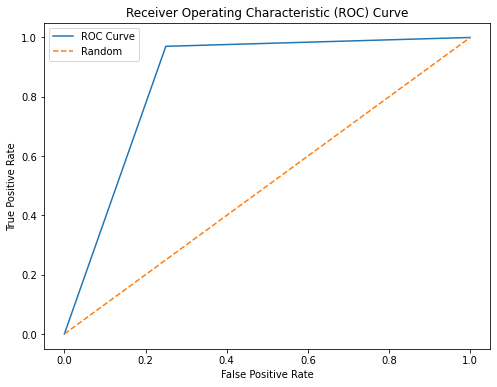

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, optimal_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, optimal_predictions)

array([[12,  4],
       [ 2, 65]], dtype=int64)

In [33]:
import pickle

dict = {
    'Model': optimal_model,
    'n_components': optimal_n_components,
    'x_train': optimal_x_train,
    'x_test': optimal_x_test,
    'predictions': optimal_predictions,
    'Test Accuracy': max_acc,
    'AUC_score': auc_score_list[optimal_n_components - 150]
}


with open('SVM_PCA.pkl', 'wb') as file:
    pickle.dump(dict, file)

## Load to verify

In [34]:
dct = pickle.load(open('SVM_PCA.pkl', 'rb'))
X_test = dct['x_test']
y_test = pickle.load(open('../Data/y_test.pkl', 'rb'))

from sklearn.metrics import accuracy_score, roc_auc_score

y_pred_test = dct['Model'].predict(X_test)
acc_score = accuracy_score(y_test, y_pred_test)
auc_score = roc_auc_score(y_test, y_pred_test)

print("Test Accuracy: ", acc_score)
print("AUC Score: ", auc_score)

Test Accuracy:  0.927710843373494
AUC Score:  0.8600746268656717
